   Maturity (years)  Discount Factor  Zero-Coupon Yield (%)
0              0.08           0.9964                 4.3378
1              0.25           0.9893                 4.3132
2              0.50           0.9789                 4.2652
3              1.00           0.9586                 4.2281
4              2.00           0.9186                 4.2450
5              3.00           0.8791                 4.2962
6              5.00           0.8034                 4.3781
7              7.00           0.7313                 4.4713
8             10.00           0.6335                 4.5644
9             30.00           0.2380                 4.7856


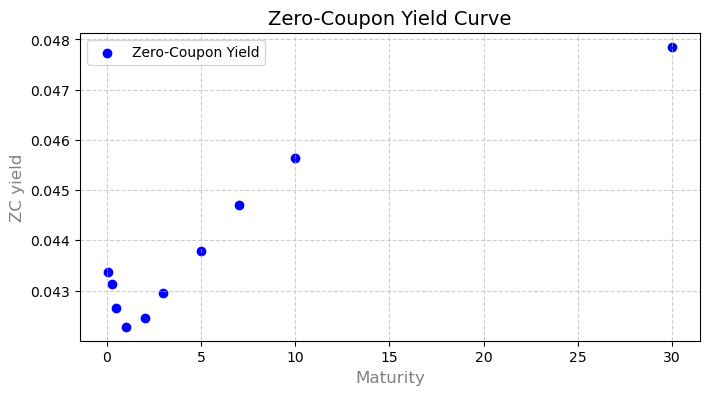

In [2]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()

    # Prepare data for DataFrame
    data = []
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        data.append([round(t, 2), round(df, 4), round(zcy, 4)])

    # Create DataFrame
    df_results = pd.DataFrame(data, columns=["Maturity (years)", "Discount Factor", "Zero-Coupon Yield (%)"])

    # Display DataFrame
    print(df_results)

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(df_results["Maturity (years)"], df_results["Zero-Coupon Yield (%)"] / 100, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

# Run the main function
main()


Nelson-Siegel-Svensson Fitting Results:
              Value
β₀         0.048668
β₁        -0.005366
β₂         0.993331
β₃         -1.00669
τ           0.99583
θ          1.004171
Objective   3.1e-06


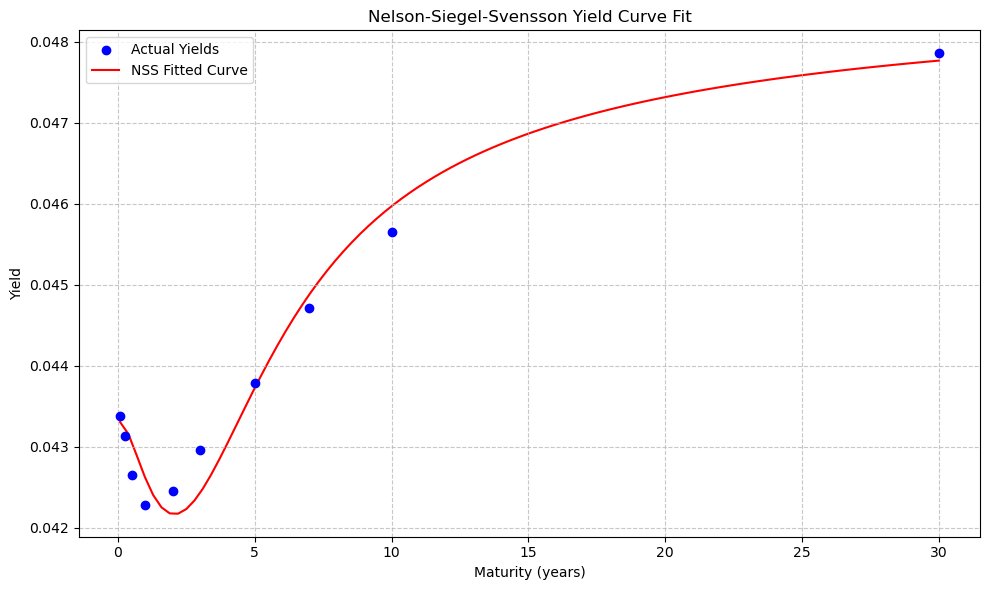

In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 1.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t, for 1m, 3m, 6m, 1yr, Bills
                          maturities)    # Long end: weight by t, for 2yr,3yr,5yr,7yr,10yr,30yr, Bonds
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.035,  # a (long-term level)
        0.01,   # b
        1.0,    # c
        -1.0,   # d
        1.0,    # tau
        1.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 0.1),     # a
        (-0.1, 0.1),  # b
        (-2, 2),      # c
        (-2, 2),      # d
        (0.1, 10),    # tau
        (0.1, 10)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result


calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
# Create DataFrame
results_df = pd.DataFrame({
    'Value': result.x
}, index=['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ'])
# Add objective function value at the bottom
obj_value = f"{result.fun:.1e}" 
results_df.loc['Objective'] = obj_value

print("\nNelson-Siegel-Svensson Fitting Results:")
print(results_df)

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


Calibrated Parameters:
      Parameter    Value
      θ (level) 0.008412
      κ (speed) 0.471040
        σ (vol) 0.080726
      v0 (init) 0.018229
   α (hump mag) 0.008617
   β (hump loc) 0.266682
Objective Value 0.033897


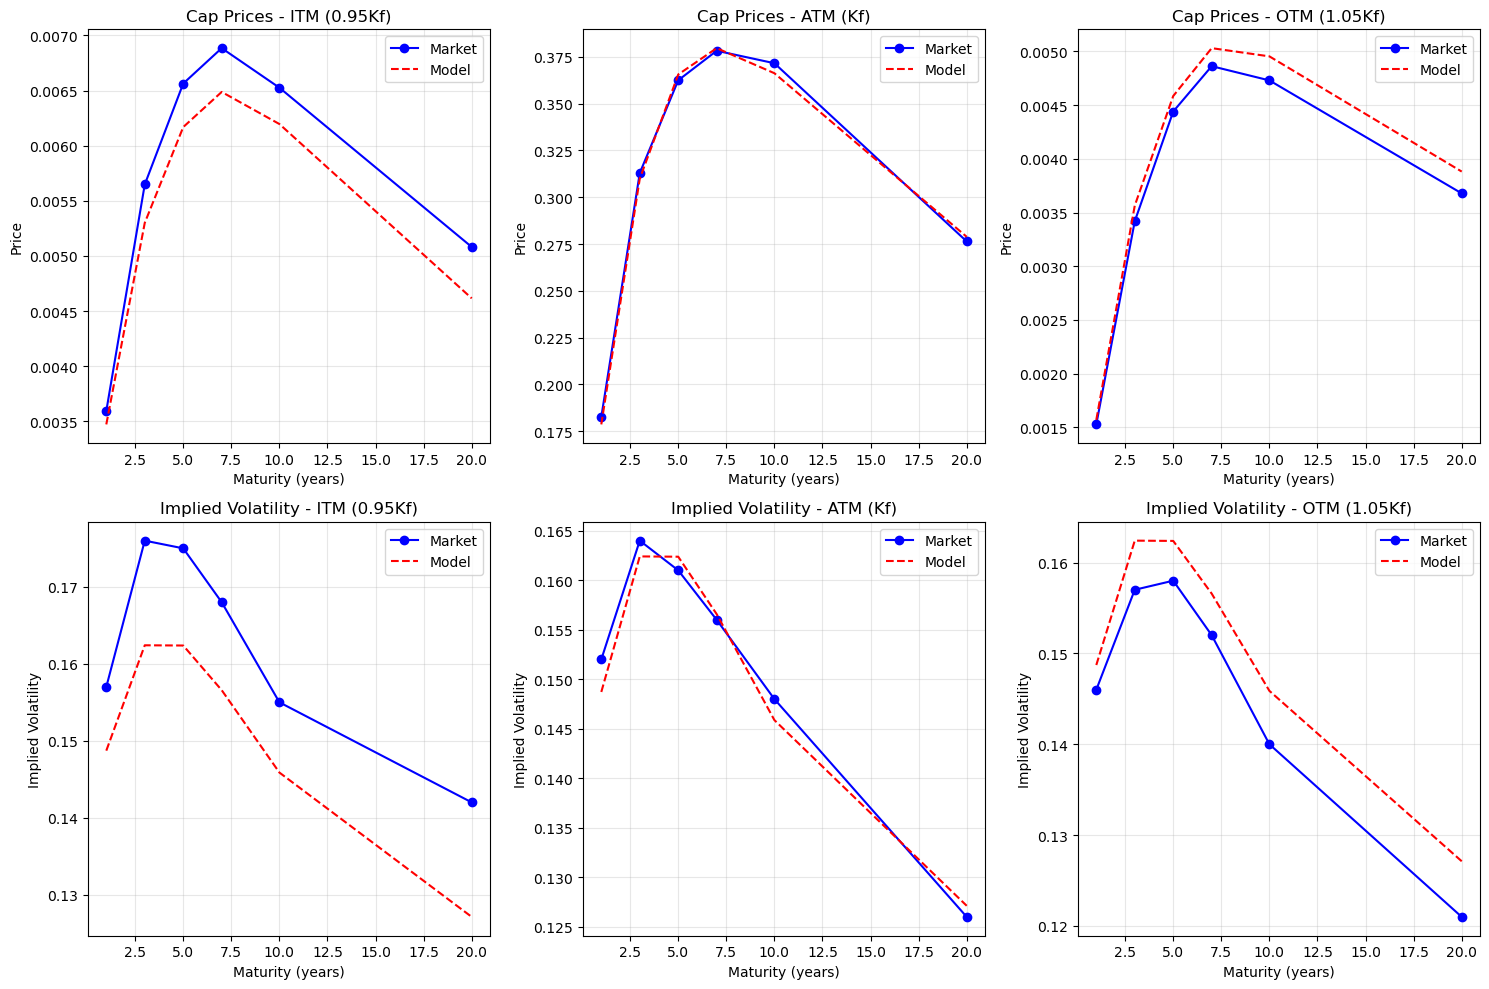

In [10]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

class ImprovedBrigoMercurio:
    def __init__(self, t = 0.003):
        self.t = t
        self.K_ratios = [0.95, 1.0, 1.05]
        self.T_years = [1, 3, 5, 7, 10, 20]
        
        # Market implied volatilities
        self.vol_market = np.array([
            [0.157, 0.152, 0.146],  # 1yr
            [0.176, 0.164, 0.157],  # 3yr
            [0.175, 0.161, 0.158],  # 5yr
            [0.168, 0.156, 0.152],  # 7yr
            [0.155, 0.148, 0.140],  # 10yr
            [0.142, 0.126, 0.121]   # 20yr
        ])
        
        self.zc_calculator = ZeroCouponCalculator()
        self._initialize_market_data()
        
    def _initialize_market_data(self):
        """Initialize discount factors and forward rates"""
        df_dict = {**self.zc_calculator.bills_discount_factors,
                  **self.zc_calculator.calculate_all_discount_factors()}
        
        self.discount_factors_dict = df_dict
        maturities = sorted(df_dict.keys())
        factors = [df_dict[t] for t in maturities]
        self.discount_factors = interp1d(maturities, factors, kind='cubic', 
                                       fill_value='extrapolate')

    def get_forward_rate(self, T):
        """Calculate forward rate"""
        dt = 0.01
        P_T = float(self.discount_factors(T))
        P_T_plus_dt = float(self.discount_factors(T + dt))
        return -(1/dt) * np.log(P_T_plus_dt/P_T)

    def black_formula(self, F, K, T, sigma, P_T):
        """Black's formula for market cap price"""
        if abs(F - K) < 1e-10:
            return P_T * sigma * np.sqrt(T/2*np.pi)
        
        d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return P_T * (F * norm.cdf(d1) - K * norm.cdf(d2))

    def enhanced_volatility(self, T, params):
        """
        Enhanced volatility function with hump shape
        Combines short-term, medium-term and long-term components
        """
        theta, kappa, sigma, v0, alpha, beta = params
        
        # Short-term component (mean-reversion)
        short_term = v0 * np.exp(-kappa * T)
        
        # Medium-term component (hump)
        hump = alpha * T * np.exp(-beta * T)
        
        # Long-term component (level)
        long_term = theta * (1 - np.exp(-kappa * T))
        
        # Volatility of volatility effect
        vol_effect = (sigma**2 / (2 * kappa)) * (1 - np.exp(-kappa * T))**2
        
        total_var = short_term + hump + long_term + vol_effect
        return np.sqrt(max(total_var, 1e-10))

    def calculate_model_quantities(self, params):
        """Calculate model prices and volatilities"""
        model_caps = np.zeros((len(self.T_years), len(self.K_ratios)))
        model_vols = np.zeros_like(model_caps)
        market_caps = np.zeros_like(model_caps)
        
        for i, T in enumerate(self.T_years):
            F = self.get_forward_rate(T)
            P_T = float(self.discount_factors(T))
            
            for j, K_ratio in enumerate(self.K_ratios):
                K = K_ratio * F
                
                # Calculate model volatility
                vol_model = self.enhanced_volatility(T, params)
                cap_model = self.black_formula(F, K, T, vol_model, P_T)
                
                # Calculate market cap price
                vol_market = self.vol_market[i, j]
                cap_market = self.black_formula(F, K, T, vol_market, P_T)
                
                model_caps[i, j] = cap_model
                model_vols[i, j] = vol_model
                market_caps[i, j] = cap_market
                
        return model_caps, model_vols, market_caps

    def objective_function(self, params):
        
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        # Price error
        price_error = 0
        for i in range(len(self.T_years)):
            for j in range(len(self.K_ratios)):
                if market_caps[i, j] != 0:
                    relative_error = (model_caps[i, j] - market_caps[i, j]) / market_caps[i, j]
                    price_error += relative_error ** 2
        return price_error

    def calibrate(self):
        """Calibrate model with enhanced parameters"""
        initial_guesses = [
            [0.02, 0.5, 0.2, 0.04, 0.1, 0.3],  # θ, κ, σ, v0, α, β
            [0.03, 0.8, 0.15, 0.03, 0.15, 0.4],
            [0.025, 0.6, 0.18, 0.035, 0.12, 0.35]
        ]
        
        bounds = [
            (0.001, 0.1),   # theta
            (0.1, 5.0),     # kappa
            (0.05, 0.5),    # sigma
            (0.001, 0.1),   # v0
            (0.0, 0.3),     # alpha (hump magnitude)
            (0.1, 1.0)      # beta (hump location)
        ]
        
        best_result = None
        best_error = float('inf')
        
        for guess in initial_guesses:
            result = opt.minimize(self.objective_function, x0=guess,
                                method='L-BFGS-B', bounds=bounds)
            
            if result.fun < best_error:
                best_error = result.fun
                best_result = result
        
        return best_result

    def plot_results(self, params):
        """Plot calibration results"""
        model_caps, model_vols, market_caps = self.calculate_model_quantities(params)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        strike_labels = ['ITM (0.95Kf)', 'ATM (Kf)', 'OTM (1.05Kf)']
        
        # Plot cap prices
        for j in range(3):
            ax = axes[0, j]
            ax.plot(self.T_years, market_caps[:, j], 'o-', label='Market', color='blue')
            ax.plot(self.T_years, model_caps[:, j], '--', label='Model', color='red')
            ax.set_title(f'Cap Prices - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Plot implied volatilities
        for j in range(3):
            ax = axes[1, j]
            ax.plot(self.T_years, self.vol_market[:, j], 'o-', 
                   label='Market', color='blue')
            ax.plot(self.T_years, model_vols[:, j], '--', 
                   label='Model', color='red')
            ax.set_title(f'Implied Volatility - {strike_labels[j]}')
            ax.set_xlabel('Maturity (years)')
            ax.set_ylabel('Implied Volatility')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

def main():
    model = ImprovedBrigoMercurio()
    result = model.calibrate()
    
    # Display parameters
    param_names = ['θ (level)', 'κ (speed)', 'σ (vol)', 'v0 (init)', 
                  'α (hump mag)', 'β (hump loc)']
    param_data = [[name, f"{val:.6f}"] for name, val in zip(param_names, result.x)]
    param_data.append(['Objective Value', f"{result.fun:.6f}"])
    
    df_params = pd.DataFrame(param_data, columns=['Parameter', 'Value'])
    print("\nCalibrated Parameters:")
    print(df_params.to_string(index=False))
    
    # Plot results
    model.plot_results(result.x)

if __name__ == "__main__":
    main()

In [133]:
import numpy as np

# Function for NSS Zero-Coupon Yield Curve, zcy(T)
def zcy(T):
    """
    Nelson-Siegel-Svensson (NSS) Zero-Coupon Yield Curve.
    :param T: time (yearly)
    :param beta0, beta1, beta2, beta3, tau1, tau2: NSS parameters get from Q2
    :return: zcy(T)
    """
    beta0 = 0.0494
    beta1 = -0.0059
    beta2 = -0.0106
    beta3 = -0.0045
    tau1 = 1.4997
    tau2 = 4.9999
    
    term1 = (1 - np.exp(-T/tau1)) / (T/tau1)
    term2 = term1 - np.exp(-T/tau1)
    term3 = (1 - np.exp(-T/tau2)) / (T/tau2) - np.exp(-T/tau2)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# Function for discount factor, P(t,T)
def P(T):
    """
    Compute P(t,T) by using zcy(T)
    :param t: current time, 0.003
    :param T: future time, yearly
    :return: P(t, T)
    """
    t = 0.003
    
    z_T = zcy(T)
    z_t = zcy(t)
    return np.exp(-z_T * (T) + z_t * t)

# Function for the Forward Rate, F(T1,T2)
def forward_rate(T1, T2):
    """
    Compute F(t, T1, T2)
    :param T1: start time
    :param T2: end time
    :return: F(T1, T2)
    """
    P_t_T1 = P(T1)
    P_t_T2 = P(T2)
    return (1 / (T2 - T1)) * np.log(P_t_T1 / P_t_T2)

# Function for the Instantaneous Forward Rate, f(0,t) NSS
def instantaneous_forward_rate(T):
    """
    Compute f(T)
    :param T: yealy date
    :return: f(T)
    """
    dt = 0.01
    P_T = P(T)
    P_T_plus_dt = P(T + dt)
    
    return -(1/dt) * np.log(P_T_plus_dt/P_T)

In [135]:
# Function for Forward Swap Rate K_f
def Kf(T):
    """
    Compute Forward Swap Rate K_f
    :param tau: quarterly settlement dates (0.25)
    :return: K_f
    """
    tau = 0.25
    denominator = 0
    
    numerator = P(tau) - P(T)
    for t in np.arange(2 * tau, T + tau, tau):
        denominator += tau * P(t)
    
    return numerator / denominator

In [153]:
# parameters
T_values = [1, 3, 5, 7, 10, 20]

# Strike Matrix
# Calculate Forward Swap Rate Kf
Kf_values = {T: Kf(T) for T in T_values}

strike_matrix = {
    "Maturity (years)": list(Kf_values.keys()),
    "0.95 K_f": [0.95 * Kf for Kf in Kf_values.values()],
    "K_f": list(Kf_values.values()),
    "1.05 K_f": [1.05 * Kf for Kf in Kf_values.values()]
}

strikes = pd.DataFrame(strike_matrix)

# IV Matrix
iv_matrix = {
    "Maturity (years)": list(Kf_values.keys()),
    "0.95 K_f": [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
    "K_f": [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
    "1.05 K_f": [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
}

sigmas = pd.DataFrame(iv_matrix)

In [155]:
# Using Black Formula to calculate the cap market price
import numpy as np
import pandas as pd
from scipy.stats import norm

def cap_mkt_price(tn, K, sigma):
    """
    :param tn: maturity time
    :param K: Strike Price
    :param sigma: Implied Volatility
    :param P_values:P(t, T)
    :param F_values: Forward Rate F(t_{j-1}, t_j)
    :return: Cap market price
    """

    cap_sum = 0
    t_values = np.arange(tau, tn + tau, tau)  # Generate time points t_j

    for i in range(len(t_values) - 1):  # Loop through time periods

        # Get the forward rate and discount factor
        F_j = forward_rate(t_values[i], t_values[i + 1])  # Forward rate for the period (t_{j-1}, t_j)
        P_j = P(t_values[i + 1])  # Discount factor for t_j

        # Compute v_j (volatility adjustment)
        v_j = sigma * np.sqrt(t_values[i])

        # Compute d1 and d2 for Black's formula
        d1 = (np.log(F_j / K) + 0.5 * v_j**2) / v_j
        d2 = (np.log(F_j / K) - 0.5 * v_j**2) / v_j

        # Compute the caplet price using Black's formula
        caplet_price = tau * P_j * (F_j * norm.cdf(d1) - K * norm.cdf(d2))
        cap_sum += caplet_price  # Accumulate caplet prices

    return cap_sum  # Return the total cap price

In [201]:
# Ensure strikes DataFrame is correctly formatted
cap_mkt_prices_df = pd.DataFrame(index=strikes.index, columns=strikes.columns[1:])  # Exclude "Maturity (years)"

# Loop through different K_f and sigma values
for i in range(strikes.shape[0]):  # Iterate through maturities
    tn = strikes.iloc[i, 0]  # Get the actual maturity year

    for j in range(1, strikes.shape[1]):  # Start from 1 to skip "Maturity (years)"
        K = strikes.iloc[i, j]  # Get strike price
        sigma = sigmas.iloc[i, j]  # Get implied volatility

        # Compute Cap Price
        cap_mkt_prices_df.iloc[i, j - 1] = cap_mkt_price(tn, K, sigma)  # j-1 to adjust for column shift

# Add Maturity column to the left
cap_mkt_prices_df.insert(0, "Maturity (years)", strikes["Maturity (years)"])

,Maturity (years),0.95 K_f,K_f,1.05 K_f
0,1,0.002109,0.001205,0.000594
1,3,0.011375,0.008055,0.005603
2,5,0.023154,0.01734,0.013529
3,7,0.035298,0.027463,0.022012
4,10,0.052099,0.04243,0.033723
5,20,0.104251,0.08184,0.06793


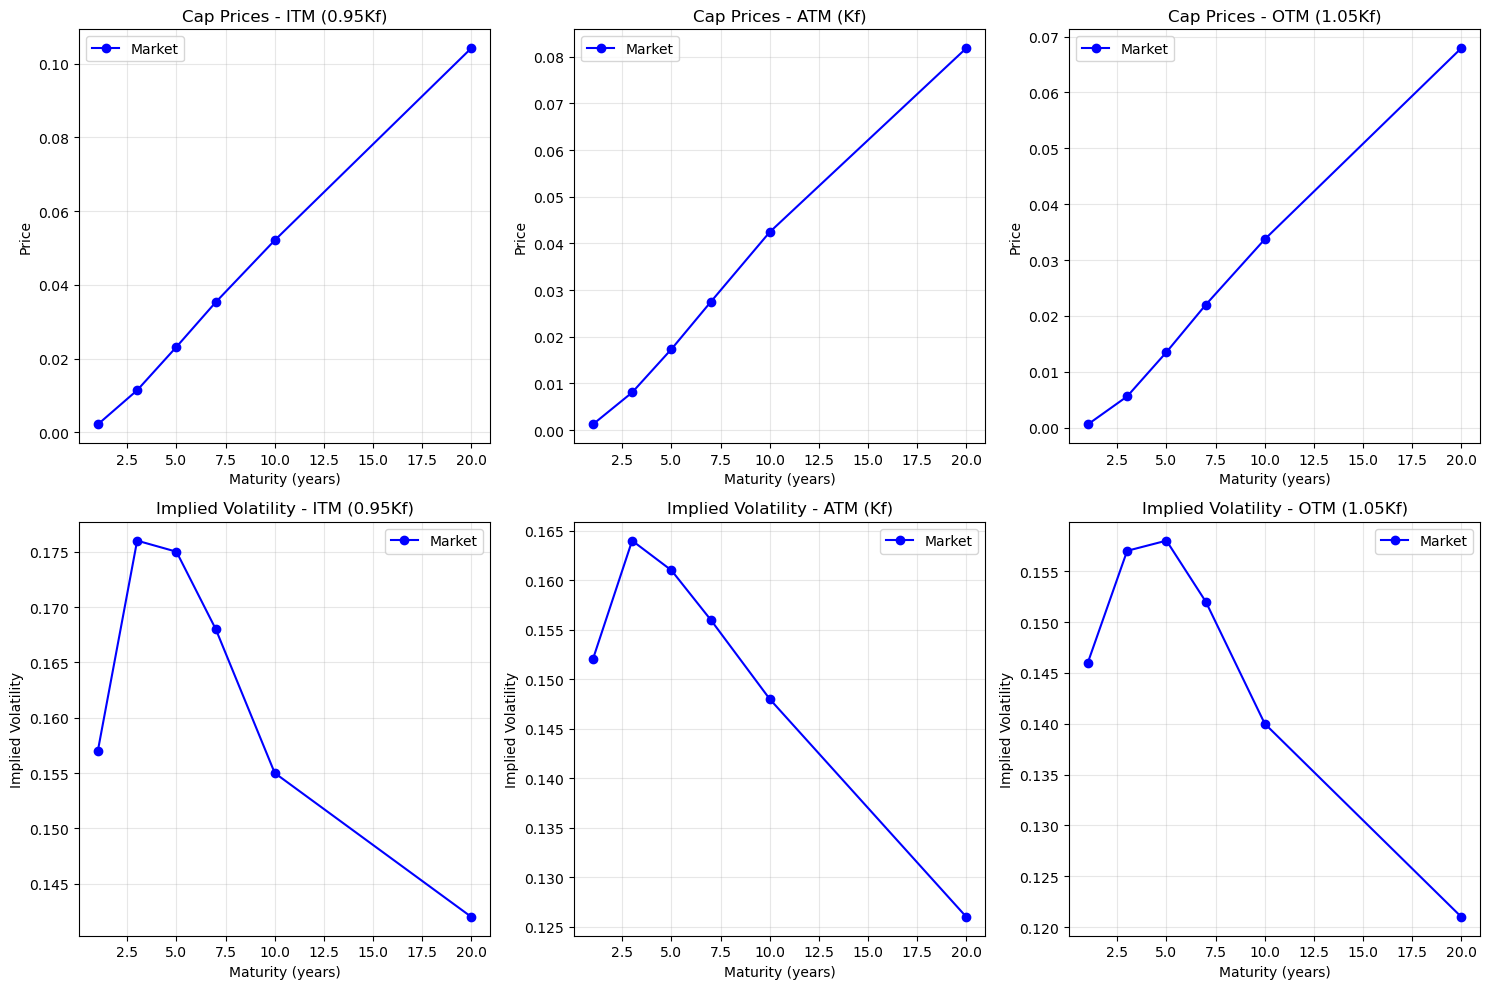

In [207]:
import matplotlib.pyplot as plt

# Extracting maturities
maturities = cap_mkt_prices_df["Maturity (years)"].values

# Extracting cap prices and implied volatilities for different strikes
cap_prices_market = {
    "0.95 K_f": cap_mkt_prices_df["0.95 K_f"].values,
    "K_f": cap_mkt_prices_df["K_f"].values,
    "1.05 K_f": cap_mkt_prices_df["1.05 K_f"].values,
}

implied_vol_market = {
    "0.95 K_f": sigmas["0.95 K_f"].values,
    "K_f": sigmas["K_f"].values,
    "1.05 K_f": sigmas["1.05 K_f"].values,
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

strikes = ["0.95 K_f", "K_f", "1.05 K_f"]
titles = ["ITM (0.95Kf)", "ATM (Kf)", "OTM (1.05Kf)"]

# First row: Cap Prices
for j in range(3):
    ax = axes[0, j]
    ax.plot(maturities, cap_prices_market[strikes[j]], "o-", label="Market", color="blue")
    ax.set_title(f"Cap Prices - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Second row: Implied Volatility
for j in range(3):
    ax = axes[1, j]
    ax.plot(maturities, implied_vol_market[strikes[j]], "o-", label="Market", color="blue")
    ax.set_title(f"Implied Volatility - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()